In [1]:
import pickle
import pandas as pd
import torch
import scipy.sparse
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import precision_score, recall_score, average_precision_score, precision_recall_curve, roc_auc_score, roc_curve 
import matplotlib.pyplot as plt


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-iele2mwu because the default path (/gpfs/home/nsj244/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
xallFile = "/gpfs/data/razavianlab/capstone/2021_ehr/preprocessed_xall_with_outcome.npz"
data = scipy.sparse.load_npz(xallFile)

In [6]:
outcomes = (data[:, -1])
outcomes = outcomes.toarray()

In [7]:
with open('mapping_dict_LARGE.pkl', 'rb') as f:
    mapping_dict = pickle.load(f)
    
with open('final_list_modified_LARGE.pkl', 'rb') as f:
    final_list_modified = pickle.load(f)
    
with open('study_indexes_LARGE.pkl', 'rb') as f:
    study_indexes = pickle.load(f)

In [8]:
len(final_list_modified)

1799820

In [9]:
max(mapping_dict.values())

59840

In [10]:
def train_downsample(NON_DEM_TO_DEM_TRAIN_RATIO, PRECENTAGE_DEMENTIA_TRAINING, dementia_outcomes, study_indexes, final_list_modified):

    train_inputs = {}

    # getting first 10% of len(dementia_outcomes == 1)
    max_train_dementia_index = int(len(np.where(dementia_outcomes == 1)[0])*PRECENTAGE_DEMENTIA_TRAINING)
    print("Amount of training dementia cases:", max_train_dementia_index)
    # getting ratio multiple of max_train_dementia_index for (dementia_outcomes == 0)
    max_train_NONdementia_index = NON_DEM_TO_DEM_TRAIN_RATIO * max_train_dementia_index
    print("Amount of training non dementia cases:", max_train_NONdementia_index)

    # concatenating indexes of dementia and non dementia studies chosen for training
    train_dem_inds = np.where(dementia_outcomes == 1)[0][:max_train_dementia_index]
    train_NONdem_inds = np.where(dementia_outcomes == 0)[0][:max_train_NONdementia_index]
    train_inds = np.concatenate((train_dem_inds,train_NONdem_inds), axis=0)

    # randomly shuffling indecies such that 0s and 1s mixed for training
    random.shuffle(train_inds)
    train_inputs["labels"] = dementia_outcomes[train_inds]
    train_inputs["input_ids"] = list(zip(np.array(study_indexes,dtype=object)[train_inds],np.array(final_list_modified,dtype=object)[train_inds]))

    print(round(len(train_inds)/len(dementia_outcomes),4), "of overall data used for train")

    return train_inputs, train_inds

def val_test_split(train_inds, study_indexes, dementia_outcomes, final_list_modified):

    val_inputs = {}
    test_inputs = {}

    train_inds.sort()
    study_trains = np.array(study_indexes)[train_inds]
    study_trains_max = study_trains[len(study_trains)-1]

    # finding last study used in training
    final_train_ind = 0
    for index, i in enumerate(study_indexes):
        if i == study_trains_max:
            final_train_ind = index


    # only considering studies that are after last train study (chance of patient overlap if including data prior to last train study)
    post_train_study_indexes = study_indexes[(final_train_ind+1):]
    post_train_final_list = final_list_modified[(final_train_ind+1):]
    post_train_dementia = dementia_outcomes[(final_train_ind+1):]

    # splitting validation and test equally
    split = len(post_train_dementia)//2

    # inputs ids
    val_inputs["input_ids"] = list(zip(post_train_study_indexes[:split],post_train_final_list[:split]))
    test_inputs["input_ids"] = list(zip(post_train_study_indexes[split:],post_train_final_list[split:]))

    # labels
    val_inputs["labels"] = post_train_dementia[:split]
    test_inputs["labels"] = post_train_dementia[split:]

    print("Amount of val cases:", len(val_inputs["labels"]), "which is ", round(len(val_inputs["labels"])/len(study_indexes),4),"of the dataset")
    print("Amount of test cases:", len(test_inputs["labels"]), "which is ", round(len(test_inputs["labels"])/len(study_indexes),4) ,"of the dataset")

    return val_inputs, test_inputs


In [11]:
import random
random.seed(10)

dementia_outcomes = []

study_indexes.sort()

for index in study_indexes:
    dementia_outcomes.append(outcomes[index])
dementia_outcomes = np.array(dementia_outcomes)

print(len(dementia_outcomes), len(study_indexes), len(final_list_modified))

# ratio of downsample
NON_DEM_TO_DEM_TRAIN_RATIO = 3
PRECENTAGE_DEMENTIA_TRAINING = .7

train_inputs, train_inds = train_downsample(NON_DEM_TO_DEM_TRAIN_RATIO, PRECENTAGE_DEMENTIA_TRAINING, dementia_outcomes, study_indexes, final_list_modified)
val_inputs, test_inputs = val_test_split(train_inds, study_indexes, dementia_outcomes, final_list_modified)

len(train_inputs["input_ids"]), len(val_inputs["input_ids"]), len(test_inputs["input_ids"])


1799820 1799820 1799820
Amount of training dementia cases: 13072
Amount of training non dementia cases: 39216
0.0291 of overall data used for train
Amount of val cases: 265121 which is  0.1473 of the dataset
Amount of test cases: 265122 which is  0.1473 of the dataset


(52288, 265121, 265122)

In [15]:
import torch.nn as nn
    
class OurDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx): 
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings["input_ids"])

### Model

In [16]:
## Without Pretrained Embeddings
#input_dim = torch.max(train_inputs['input_ids'])
from torch.nn.utils.rnn import pad_sequence
def padded_ids(train_inputs, features):
    emb_matrix = torch.zeros((len(train_inputs), features + 1))
    
    for i, (pid, cids) in enumerate(train_inputs):
        for cid in cids:
            emb_matrix[i, cid] = 1
        
    return emb_matrix
    
    

In [17]:
features = max([max(train_inputs['input_ids'][i][1]) for i in range(len(train_inputs['input_ids']))])

In [18]:
features

59840

In [19]:
ids = train_inputs['input_ids'][0:16]
#padded_ids(ids, features)
#padded_to_onehot(padded_ids(ids), max(mapping_dict.values()))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [20]:
class LogisticRegressionV2(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionV2, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = torch.nn.Linear(self.input_dim+1, 2)
        
    def forward(self, x):
        x = padded_ids(x, self.input_dim).to(device)
        outputs = self.linear(x)

        return outputs

In [21]:
batch_size = 32
epochs = 3
lr_rate = 0.01
input_dim = features
output_dim = 2

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print("sending model to ", device)

sending model to  cuda


In [23]:
model = LogisticRegressionV2(input_dim, output_dim).to(device)

criterion = torch.nn.CrossEntropyLoss(weight = torch.tensor((1.0,3.0))).to(device) # computes softmax and then the cross entropy
softmax = torch.nn.Softmax(dim=1)
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

model.train()

LogisticRegressionV2(
  (linear): Linear(in_features=59841, out_features=2, bias=True)
)

### Training

In [24]:

train_labels = []
train_probs = []
for epoch in range(epochs):

    print ('epoch', epoch)

    start = 0
    end = batch_size
    iteration = 0
    loss_avg = 0
    while end < len(train_inputs["input_ids"]): 

        x = train_inputs["input_ids"][start:end]
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)

        labels = torch.tensor([int(x) for x in train_inputs['labels'][start:end] ])
        train_y_prob = softmax(outputs)[:,1].detach()

        # appending metrics
        train_probs.append(train_y_prob)
        train_labels.append(labels)

        # step
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_avg += loss
        # saving model
        if (iteration%500 == 0):
            print (iteration, loss_avg/500)
            #file.write(str(epoch) + " at iteration " + str(iteration) + "\n")
            #file.write("loss " + str(loss) + "\n")
            #torch.save(model, 'model.pkl')
            loss_avg = 0
        
        iteration += 1
        start += batch_size
        end += batch_size

epoch 0
0 tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
500 tensor(0.6930, device='cuda:0', grad_fn=<DivBackward0>)
1000 tensor(0.6936, device='cuda:0', grad_fn=<DivBackward0>)
1500 tensor(0.6932, device='cuda:0', grad_fn=<DivBackward0>)
epoch 1
0 tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
500 tensor(0.6924, device='cuda:0', grad_fn=<DivBackward0>)
1000 tensor(0.6927, device='cuda:0', grad_fn=<DivBackward0>)
1500 tensor(0.6924, device='cuda:0', grad_fn=<DivBackward0>)
epoch 2
0 tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
500 tensor(0.6918, device='cuda:0', grad_fn=<DivBackward0>)
1000 tensor(0.6920, device='cuda:0', grad_fn=<DivBackward0>)
1500 tensor(0.6918, device='cuda:0', grad_fn=<DivBackward0>)


In [25]:
def train_metrics(labs, probs):
    np_labs = torch.cat(labs).numpy()
    np_probs = torch.cat(probs).cpu().numpy()
    precision, recall, thresholds = precision_recall_curve(np_labs,np_probs)
    avg_precision = average_precision_score(np_labs,np_probs)
    
    fpr, tpr, thresholds = roc_curve(np_labs, np_probs)
    auc = roc_auc_score(np_labs,np_probs)
    return precision, recall, avg_precision, auc, fpr, tpr, thresholds

In [26]:
precision, recall, avg_precision, auc, fpr, tpr, thresholds = train_metrics(train_labels, train_probs)

In [27]:
avg_precision

0.2577018502104942

In [28]:
auc

0.5084639823910572

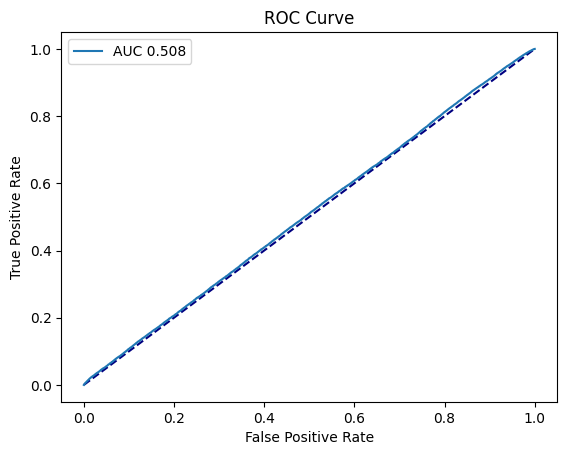

In [29]:
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.plot(fpr, tpr, label='AUC {}'.format(round(auc, 3)))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [30]:
len(np.where(train_inputs['labels'] == 1)[0])/len(train_inputs['labels'])

0.25

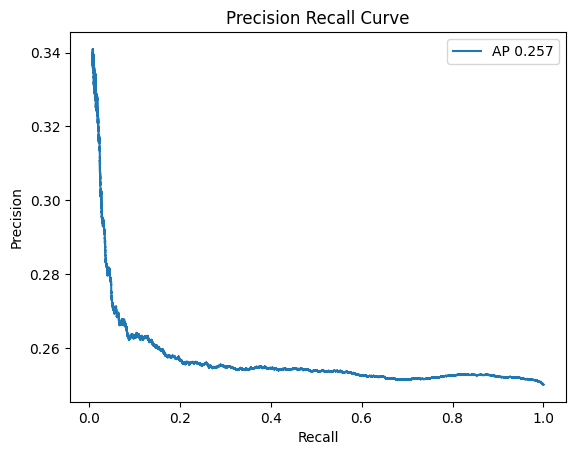

In [40]:
plt.plot(recall[:-1000], precision[:-1000], label='AP {}'.format(.257))
plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.axhline(y=0.25, color='r', linestyle='-', label="No Skill")# plt.ylim([0, 1.1])

plt.legend()
plt.show()

### Validation

In [35]:

val_batch = batch_size
v_start = 0
v_end = batch_size
val_iteration = 0
val_loss = 0
num_correct = 0
precisions = []
#recalls = []
test_probs = []
test_labels = []
with torch.no_grad():
    #for val_batch in val_dataloader:
    while v_end < len(val_inputs["input_ids"]): 
        val_iteration+=1
        outputs_val = model(val_inputs["input_ids"][v_start:v_end])
        val_y_prob = softmax(outputs_val)[:,1]
        _, predicted_val = torch.max(outputs_val, 1)

        labels_val = torch.tensor([int(x) for x in val_inputs['labels'][v_start:v_end]])
        val_loss = criterion(outputs_val, labels_val)
        val_loss+= val_loss

        precisions.append(precision_score(labels_val,predicted_val,zero_division=0))
        recalls.append(recall_score(labels_val,predicted_val))
        num_correct += torch.sum(predicted_val == labels_val)

        v_start += batch_size
        v_end += batch_size


    print ('validation loss at', str(iteration), val_loss/len(val_dataset))
    print ('accuracy at', str(iteration), num_correct/len(val_dataset))
    print ('avg precision at', str(iteration), np.mean(precisions))
    print ('avg recall at', str(iteration), np.mean(recalls))
    print ('')
    print ('')
    print ('')


### Test

In [117]:
total_test_correct = 0.0
examples = []

t_start = 0
t_end = batch_size
test_iteration = 0
test_loss = 0
num_correct = 0
precisions = []
test_probs = []
test_labels = []

with torch.no_grad():
    while t_end < len(test_inputs["input_ids"]): 
        test_iteration+=1
        outputs_test = model(test_inputs["input_ids"][t_start:t_end])
        test_y_prob = softmax(outputs_test)[:,1]
        _, predicted_test = torch.max(outputs_test, 1)

        labels_test = torch.tensor([int(x) for x in test_inputs['labels'][t_start:t_end]])
        test_loss = criterion(outputs_test, labels_test)
        test_loss += test_loss

        precisions.append(precision_score(labels_test,predicted_test,zero_division=0))
        num_correct += torch.sum(predicted_test == labels_test)
        
        test_probs.append(test_y_prob)
        test_labels.append(labels_test)
        
        t_start += batch_size
        t_end += batch_size


    print ('test loss:', test_loss/len(test_inputs["input_ids"]))
    print ('accuracy:', num_correct/len(test_inputs["input_ids"]))


test loss: tensor(2.6665e-06)
accuracy: tensor(0.9908)


In [133]:
t_precision, t_recall, t_avg_precision, t_auc, t_fpr, t_tpr, thresholds = train_metrics(test_labels, test_probs)

In [134]:
t_auc

0.5078796984119686

In [135]:
t_avg_precision

0.008649486303289903